# Load Trained Q and Policy

In [4]:
import pickle

agent_name = "MCES"

with open(f"agent_{agent_name}_policy.pkl", "rb") as f:
    policy = pickle.load(f)
with open(f"agent_{agent_name}_Q.pkl", "rb") as f:
    Q = pickle.load(f)

for s, a in Q:
    print(f"State: {s}, Action: {a}, Q-value: {Q[(s, a)]}")

for s in policy:
    print(f"State: {s}, Action: {policy[s]}")

State: BaseState(player_sum=13, dealer_card=8, usible_ace=True, splitable=False), Action: Action.Double, Q-value: 0.6666666666666666
State: BaseState(player_sum=13, dealer_card=8, usible_ace=True, splitable=False), Action: Action.Stand, Q-value: -2.0
State: BaseState(player_sum=18, dealer_card=8, usible_ace=False, splitable=False), Action: Action.Hit, Q-value: -0.9090909090909088
State: BaseState(player_sum=18, dealer_card=8, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: -1.0
State: BaseState(player_sum=19, dealer_card=8, usible_ace=True, splitable=False), Action: Action.Hit, Q-value: -0.25
State: BaseState(player_sum=19, dealer_card=8, usible_ace=True, splitable=False), Action: Action.Stand, Q-value: -1.0
State: BaseState(player_sum=15, dealer_card=8, usible_ace=True, splitable=False), Action: Action.Hit, Q-value: -1.0
State: BaseState(player_sum=15, dealer_card=8, usible_ace=True, splitable=False), Action: Action.Stand, Q-value: -1.0
State: BaseState(player_sum=1

Action: Action.Stand
State: BaseState(player_sum=2, dealer_card=3, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: -3.0
State: BaseState(player_sum=2, dealer_card=8, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: -2.0
State: BaseState(player_sum=3, dealer_card=9, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: -1.0
State: BaseState(player_sum=4, dealer_card=2, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: -3.0
State: BaseState(player_sum=5, dealer_card=4, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: -1.0
State: BaseState(player_sum=5, dealer_card=5, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: 1.0
State: BaseState(player_sum=6, dealer_card=3, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: 1.0
State: BaseState(player_sum=6, dealer_card=11, usible_ace=False, splitable=False), Action: Action.Stand, Q-value: -4.0
State: BaseState(player_sum=7, deale

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

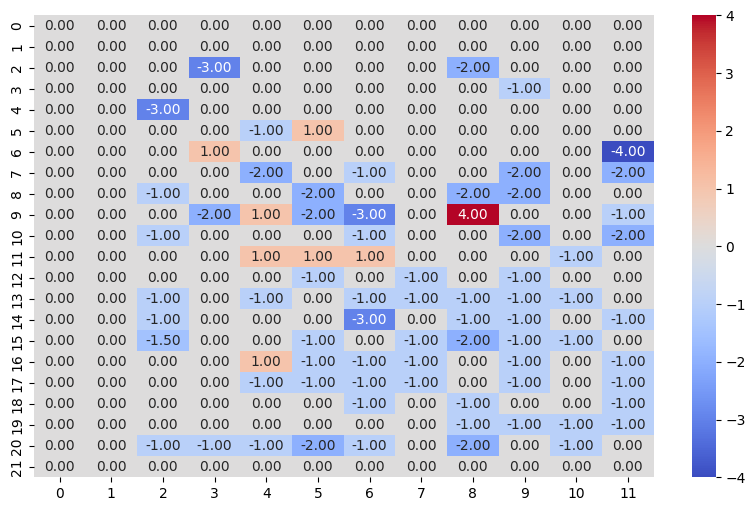

In [ ]:
from models.utils import BaseState, Action
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# split q a tables
player_sums = range(0, 22)
dealer_cards = range(0, 12)

# action tables
action_tables = {}
for action in [Action.Stand, Action.Hit, Action.Double]:
    print(f"Action: {action}")
    action_tables[action] = np.zeros((len(player_sums), len(dealer_cards)))
    for player_sum in player_sums:
        for dealer_card_value in dealer_cards:
            state = BaseState(
                player_sum=player_sum,
                dealer_card=dealer_card_value,
                usible_ace=False,
                splitable=False
            )
            if (state, action) in Q:
                print(f"State: {state}, Action: {action}, Q-value: {Q[(state, action)]}")
                action_tables[action][player_sum, dealer_card_value] = Q[(state, action)]


for action, table in action_tables.items():
    plt.figure(figsize=(10, 6))
    # plt.imshow(table, cmap='hot', interpolation='nearest')
    sns.heatmap(table, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
                xticklabels=dealer_cards, yticklabels=player_sums)
    # plt.colorbar(label='Q-value')
    plt.title(f'Q-values for Action: {action}')
    plt.xlabel('Dealer Card')
    plt.ylabel('Player Sum')
    plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
    plt.yticks(ticks=np.arange(len(player_sums)), labels=player_sums)
    plt.show()
